In [20]:
import numpy as np
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import utils as ut
import importlib

In [23]:
COMMON_PATH = "../data/COMMON_images_masks/common_"
GROUP_PATH = "../data/g3_"

# 1.Data Exploration

In [24]:
importlib.reload(ut)
filename = COMMON_PATH + '40_image.nii.gz'
maskname = COMMON_PATH + '40_mask.nii.gz' 
pelvic_img, pelvic_img_data = ut.read_image(filename)
pelvic_mask, pelvic_mask_data = ut.read_image(maskname)

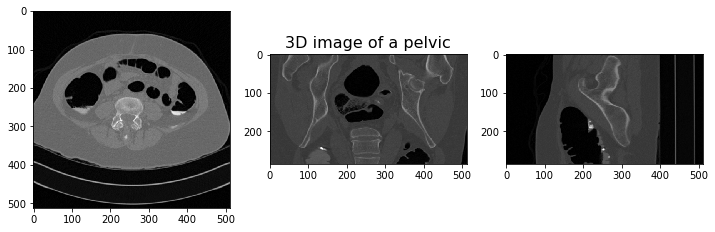

In [26]:
importlib.reload(ut)
ut.plot_3d_img(pelvic_img, pelvic_img_data)

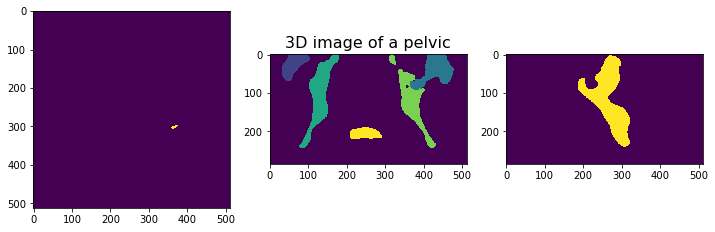

In [27]:
ut.plot_3d_img(pelvic_mask, pelvic_mask_data, cmap="viridis")